# AQI Prediction - Model Training & Evaluation

This notebook covers:
1. **Data Loading** from MongoDB Feature Store
2. **Feature Selection** (Top features by correlation)
3. **Model Training** (XGBoost, LightGBM, Random Forest, Logistic Regression)
4. **SHAP/LIME Analysis** for interpretability
5. **Model Evaluation** (RMSE, MAE, R²)
6. **Model Storage** (Local .pkl + MongoDB Registry)

**Target**: Predict AQI number (regression) for next 3 days

## 1. Import Libraries & Configure Environment

In [1]:
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Model interpretation
import shap
# from lime import lime_tabular  # Optional: for LIME

# Model persistence
import joblib
import pickle

# MongoDB
from pymongo import MongoClient
from pymongo.server_api import ServerApi
from src.config import Config
from src.data.mongodb_handler import MongoDBHandler

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"📂 Project Root: {project_root}")

✅ All libraries imported successfully!
📂 Project Root: d:\Internships and Jobs Data\10 Pearls Shine Internship\Project\AQI Predictor


## 2. Load Data from MongoDB Feature Store

In [2]:
# Initialize MongoDB handler
db_handler = MongoDBHandler()

# Fetch all historical features
print("📥 Fetching data from MongoDB...")
data = db_handler.query_features(collection_name='historical_features', limit=None)

if data.empty:
    raise ValueError("❌ No data found in MongoDB! Run setup_historical.py first.")

print(f"✅ Loaded {len(data)} rows from MongoDB")
print(f"📅 Date Range: {data['timestamp'].min()} to {data['timestamp'].max()}")
print(f"📊 Shape: {data.shape}")
print(f"\n🔍 Columns: {list(data.columns)}")

📥 Fetching data from MongoDB...
✅ Loaded 2254 rows from MongoDB
📅 Date Range: 2025-11-01 00:00:00 to 2026-02-05 20:00:00
📊 Shape: (2254, 121)

🔍 Columns: ['timestamp', 'aqi', '_id', 'temperature', 'humidity', 'dew_point', 'precipitation', 'pressure', 'wind_speed', 'wind_direction', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'year', 'month', 'day', 'hour', 'weekday', 'is_weekend', 'season', 'time_of_day', 'aqi_lag_1', 'aqi_lag_6', 'aqi_lag_12', 'aqi_lag_24', 'pm2_5_lag_1', 'pm2_5_lag_6', 'pm2_5_lag_12', 'pm2_5_lag_24', 'pm10_lag_1', 'pm10_lag_6', 'pm10_lag_12', 'pm10_lag_24', 'co_lag_1', 'co_lag_6', 'co_lag_12', 'co_lag_24', 'no2_lag_1', 'no2_lag_6', 'no2_lag_12', 'no2_lag_24', 'aqi_rolling_mean_6h', 'aqi_rolling_std_6h', 'aqi_rolling_min_6h', 'aqi_rolling_max_6h', 'aqi_rolling_mean_12h', 'aqi_rolling_std_12h', 'aqi_rolling_min_12h', 'aqi_rolling_max_12h', 'aqi_rolling_mean_24h', 'aqi_rolling_std_24h', 'aqi_rolling_min_24h', 'aqi_rolling_max_24h', 'pm2_5_rolling_mean_6h', '

In [3]:
# Display basic info
print("📋 Dataset Info:")
print(data.info())
print("\n📊 Statistical Summary:")
print(data.describe())
print("\n🔍 Missing Values:")
print(data.isnull().sum()[data.isnull().sum() > 0])

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Columns: 121 entries, timestamp to high_temp_alert
dtypes: datetime64[ns](1), float64(106), int64(13), object(1)
memory usage: 2.1+ MB
None

📊 Statistical Summary:
                           timestamp          aqi  temperature     humidity  \
count                           2254  2254.000000  2254.000000  2254.000000   
mean   2025-12-18 08:40:42.058562560     4.204969    19.745910    51.773525   
min              2025-11-01 00:00:00     2.000000     7.300000     9.499662   
25%              2025-11-24 11:15:00     3.000000    15.562500    34.662435   
50%              2025-12-17 22:30:00     4.000000    19.225000    50.550087   
75%              2026-01-11 09:45:00     5.000000    23.799999    68.707346   
max              2026-02-05 20:00:00     5.000000    35.950001    98.155647   
std                              NaN     0.874074     5.554425    20.979243   

         dew_point  precipitation 

## 3. Feature Engineering & Selection

In [4]:
# Prepare data for modeling
df = data.copy()

# Drop non-feature columns
columns_to_drop = ['timestamp', '_id']
df_clean = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Separate features and target
target_col = 'aqi'
if target_col not in df_clean.columns:
    raise ValueError(f"❌ Target column '{target_col}' not found in data!")

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")
print(f"📊 Target (AQI) range: {y.min():.2f} - {y.max():.2f}")
print(f"📊 Target (AQI) mean: {y.mean():.2f} ± {y.std():.2f}")

✅ Features shape: (2254, 118)
✅ Target shape: (2254,)
📊 Target (AQI) range: 2.00 - 5.00
📊 Target (AQI) mean: 4.20 ± 0.87


In [5]:
# Feature correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Select top 40 features
top_n = 40
top_features = correlations.head(top_n).index.tolist()

print(f"🔝 Top {top_n} Features by Correlation with AQI:\n")
for i, (feature, corr) in enumerate(correlations.head(top_n).items(), 1):
    print(f"{i:2d}. {feature:40s} : {corr:.4f}")

# Filter dataset to top features
X_selected = X[top_features]
print(f"\n✅ Selected {len(top_features)} features for modeling")
print(f"📊 Selected features shape: {X_selected.shape}")

🔝 Top 40 Features by Correlation with AQI:

 1. aqi_lag_1                                : 0.9532
 2. aqi_rolling_mean_6h                      : 0.9339
 3. aqi_rolling_min_6h                       : 0.9117
 4. aqi_rolling_max_6h                       : 0.8918
 5. high_pollution_alert                     : 0.8690
 6. aqi_rolling_mean_12h                     : 0.8641
 7. aqi_rolling_min_12h                      : 0.8292
 8. aqi_rolling_mean_24h                     : 0.8034
 9. aqi_rolling_max_12h                      : 0.7951
10. pm10                                     : 0.7824
11. pm10_lag_1                               : 0.7743
12. pm10_rolling_mean_6h                     : 0.7600
13. pm10_rolling_min_6h                      : 0.7578
14. aqi_lag_6                                : 0.7574
15. aqi_rolling_min_24h                      : 0.7526
16. pm10_rolling_max_6h                      : 0.7457
17. pm2_5                                    : 0.7323
18. pm2_5_lag_1                       

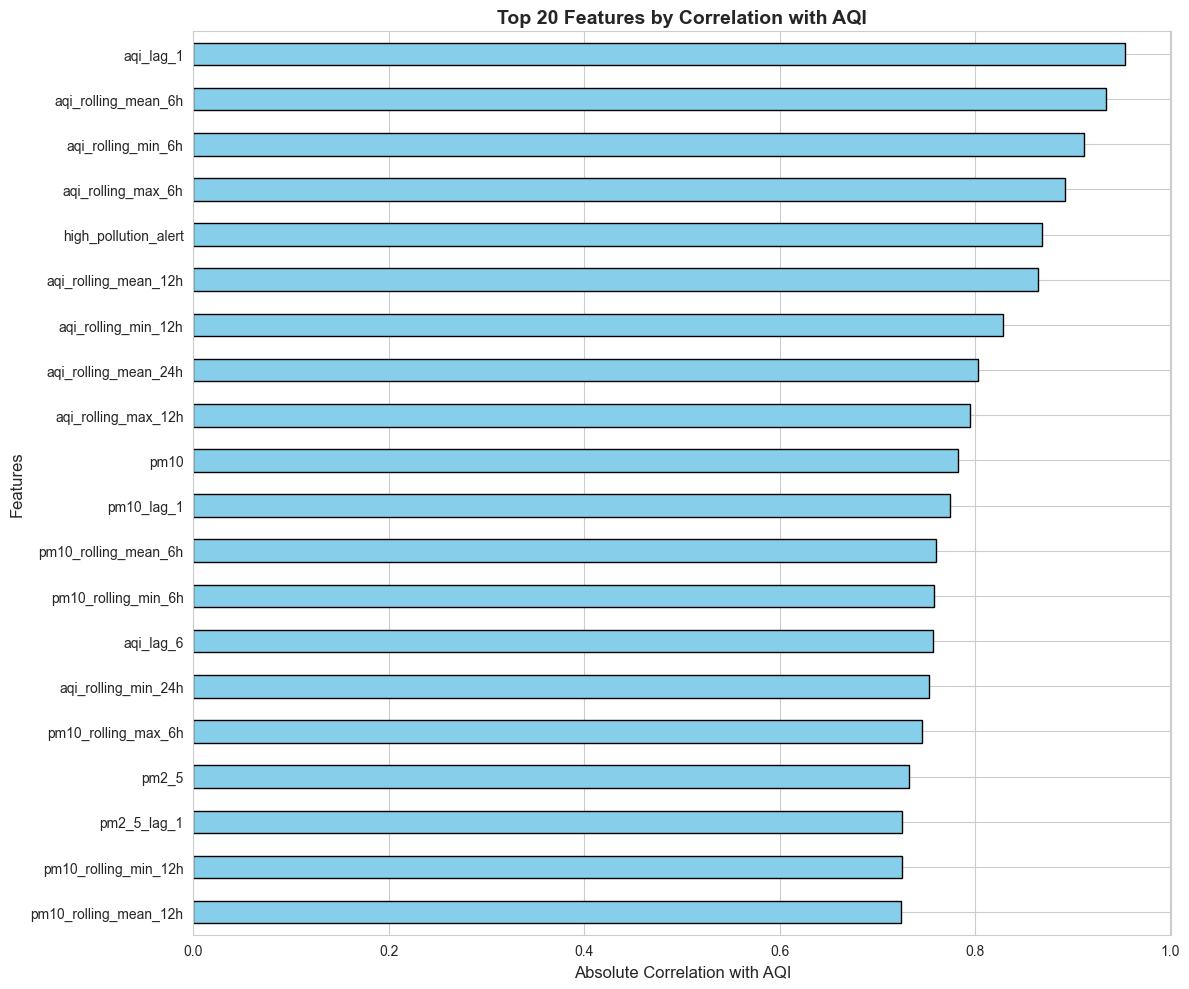

In [6]:
# Visualize top feature correlations
plt.figure(figsize=(12, 10))
correlations.head(20).plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Absolute Correlation with AQI', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Features by Correlation with AQI', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Train-Test Split (Time-Based)

In [8]:
# Time-based split (70% train, 15% validation, 15% test)
n = len(X_selected)
train_size = int(0.70 * n)
val_size = int(0.15 * n)

X_train = X_selected.iloc[:train_size]
X_val = X_selected.iloc[train_size:train_size+val_size]
X_test = X_selected.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size+val_size]
y_test = y.iloc[train_size+val_size:]

print("📊 Dataset Split (Time-Based):")
print(f"   Train: {len(X_train):,} samples ({len(X_train)/n*100:.1f}%)")
print(f"   Val:   {len(X_val):,} samples ({len(X_val)/n*100:.1f}%)")
print(f"   Test:  {len(X_test):,} samples ({len(X_test)/n*100:.1f}%)")
print(f"\n✅ Train: {data['timestamp'].iloc[0]} to {data['timestamp'].iloc[train_size-1]}")
print(f"✅ Val:   {data['timestamp'].iloc[train_size]} to {data['timestamp'].iloc[train_size+val_size-1]}")
print(f"✅ Test:  {data['timestamp'].iloc[train_size+val_size]} to {data['timestamp'].iloc[-1]}")

📊 Dataset Split (Time-Based):
   Train: 1,577 samples (70.0%)
   Val:   338 samples (15.0%)
   Test:  339 samples (15.0%)

✅ Train: 2025-11-01 00:00:00 to 2026-01-06 16:00:00
✅ Val:   2026-01-06 17:00:00 to 2026-01-20 18:00:00
✅ Test:  2026-01-20 19:00:00 to 2026-02-05 20:00:00


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"   Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")

✅ Features scaled using StandardScaler
   Mean: -0.0000, Std: 1.0000


## 5. Model Training (4 Regression Models)

In [10]:
# Dictionary to store models and results
models = {}
results = {}

# Helper function to evaluate models
def evaluate_model(name, y_true, y_pred):
    """Calculate RMSE, MAE, and R² for model evaluation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

print("🤖 Initializing 4 regression models...")

🤖 Initializing 4 regression models...


### 5.1 XGBoost Regressor

In [11]:
print("🚀 Training XGBoost Regressor...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train,
              eval_set=[(X_val_scaled, y_val)],
              verbose=False)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
results['XGBoost'] = {
    'train': evaluate_model('XGBoost Train', y_train, y_train_pred_xgb),
    'val': evaluate_model('XGBoost Val', y_val, y_val_pred_xgb),
    'test': evaluate_model('XGBoost Test', y_test, y_test_pred_xgb)
}

models['XGBoost'] = xgb_model

print(f"✅ XGBoost - Train RMSE: {results['XGBoost']['train']['RMSE']:.4f}, Val RMSE: {results['XGBoost']['val']['RMSE']:.4f}, Test RMSE: {results['XGBoost']['test']['RMSE']:.4f}")

🚀 Training XGBoost Regressor...
✅ XGBoost - Train RMSE: 0.0016, Val RMSE: 0.1170, Test RMSE: 0.1997


### 5.2 LightGBM Regressor

In [12]:
print("🚀 Training LightGBM Regressor...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train_scaled, y_train,
              eval_set=[(X_val_scaled, y_val)])

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train_scaled)
y_val_pred_lgb = lgb_model.predict(X_val_scaled)
y_test_pred_lgb = lgb_model.predict(X_test_scaled)

# Evaluate
results['LightGBM'] = {
    'train': evaluate_model('LightGBM Train', y_train, y_train_pred_lgb),
    'val': evaluate_model('LightGBM Val', y_val, y_val_pred_lgb),
    'test': evaluate_model('LightGBM Test', y_test, y_test_pred_lgb)
}

models['LightGBM'] = lgb_model

print(f"✅ LightGBM - Train RMSE: {results['LightGBM']['train']['RMSE']:.4f}, Val RMSE: {results['LightGBM']['val']['RMSE']:.4f}, Test RMSE: {results['LightGBM']['test']['RMSE']:.4f}")

🚀 Training LightGBM Regressor...
✅ LightGBM - Train RMSE: 0.0390, Val RMSE: 0.1124, Test RMSE: 0.1923


### 5.3 Random Forest Regressor

In [13]:
print("🚀 Training Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
results['RandomForest'] = {
    'train': evaluate_model('RandomForest Train', y_train, y_train_pred_rf),
    'val': evaluate_model('RandomForest Val', y_val, y_val_pred_rf),
    'test': evaluate_model('RandomForest Test', y_test, y_test_pred_rf)
}

models['RandomForest'] = rf_model

print(f"✅ RandomForest - Train RMSE: {results['RandomForest']['train']['RMSE']:.4f}, Val RMSE: {results['RandomForest']['val']['RMSE']:.4f}, Test RMSE: {results['RandomForest']['test']['RMSE']:.4f}")

🚀 Training Random Forest Regressor...
✅ RandomForest - Train RMSE: 0.0348, Val RMSE: 0.1099, Test RMSE: 0.2015


### 5.4 Linear Regression

In [14]:
print("🚀 Training Linear Regression (baseline)...")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
results['LinearRegression'] = {
    'train': evaluate_model('LinearRegression Train', y_train, y_train_pred_lr),
    'val': evaluate_model('LinearRegression Val', y_val, y_val_pred_lr),
    'test': evaluate_model('LinearRegression Test', y_test, y_test_pred_lr)
}

models['LinearRegression'] = lr_model

print(f"✅ LinearRegression - Train RMSE: {results['LinearRegression']['train']['RMSE']:.4f}, Val RMSE: {results['LinearRegression']['val']['RMSE']:.4f}, Test RMSE: {results['LinearRegression']['test']['RMSE']:.4f}")

🚀 Training Linear Regression (baseline)...
✅ LinearRegression - Train RMSE: 0.1578, Val RMSE: 0.2259, Test RMSE: 0.2381


## 6. Model Comparison & Best Model Selection

In [15]:
# Create comparison table
comparison_data = []

for model_name, metrics in results.items():
    for split, values in metrics.items():
        comparison_data.append({
            'Model': model_name,
            'Split': split,
            'RMSE': values['RMSE'],
            'MAE': values['MAE'],
            'R²': values['R²']
        })

comparison_df = pd.DataFrame(comparison_data)

# Display results
print("\n" + "="*80)
print("📊 MODEL PERFORMANCE COMPARISON")
print("="*80 + "\n")

for model_name in results.keys():
    model_df = comparison_df[comparison_df['Model'] == model_name]
    print(f"\n{model_name}:")
    print(model_df[['Split', 'RMSE', 'MAE', 'R²']].to_string(index=False))
    
print("\n" + "="*80)


📊 MODEL PERFORMANCE COMPARISON


XGBoost:
Split     RMSE      MAE       R²
train 0.001581 0.000475 0.999996
  val 0.117017 0.023303 0.981072
 test 0.199668 0.072546 0.947856

LightGBM:
Split     RMSE      MAE       R²
train 0.039000 0.009927 0.997778
  val 0.112379 0.035591 0.982542
 test 0.192269 0.079583 0.951649

RandomForest:
Split     RMSE      MAE       R²
train 0.034761 0.004774 0.998235
  val 0.109873 0.015120 0.983312
 test 0.201496 0.073082 0.946897

LinearRegression:
Split     RMSE      MAE       R²
train 0.157830 0.104602 0.963604
  val 0.225869 0.156300 0.929477
 test 0.238055 0.159363 0.925879



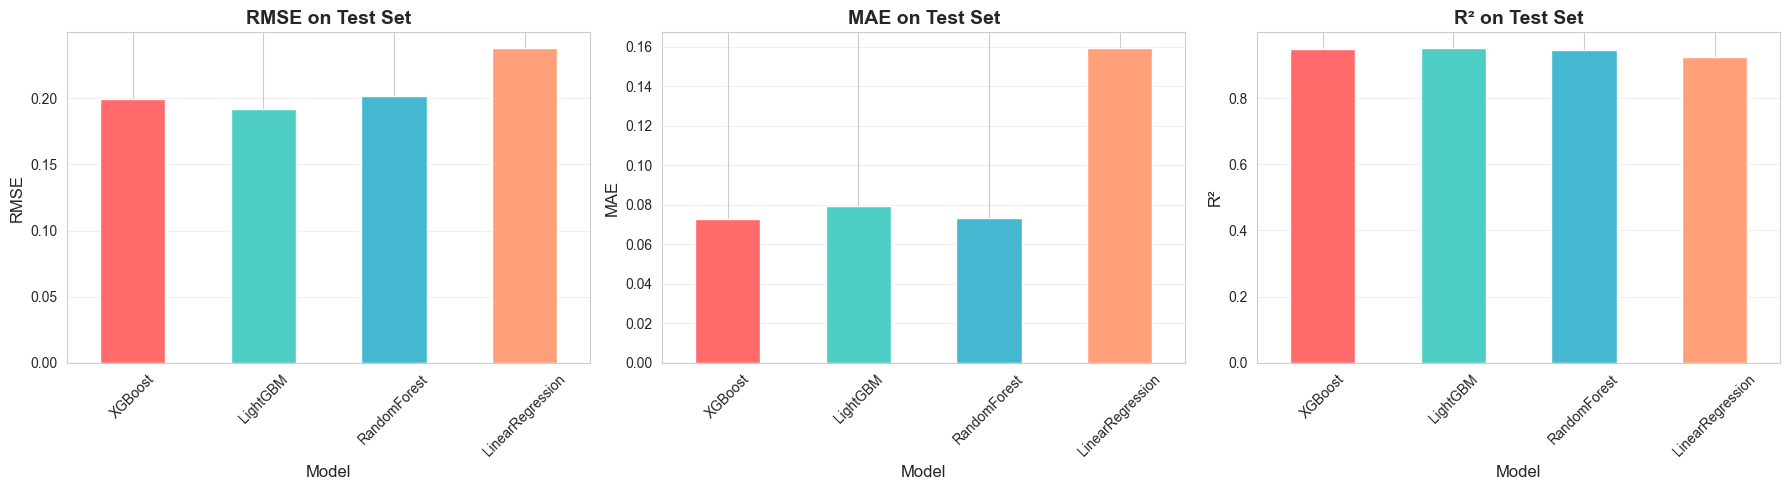


✅ Visualization complete!


In [16]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['RMSE', 'MAE', 'R²']
for idx, metric in enumerate(metrics_to_plot):
    test_results = comparison_df[comparison_df['Split'] == 'test']
    test_results.plot(x='Model', y=metric, kind='bar', ax=axes[idx], 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], 
                      legend=False, rot=45)
    axes[idx].set_title(f'{metric} on Test Set', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

In [17]:
# Select best model based on test RMSE
test_results = comparison_df[comparison_df['Split'] == 'test']
best_model_name = test_results.loc[test_results['RMSE'].idxmin(), 'Model']
best_model = models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test RMSE: {results[best_model_name]['test']['RMSE']:.4f}")
print(f"   Test MAE:  {results[best_model_name]['test']['MAE']:.4f}")
print(f"   Test R²:   {results[best_model_name]['test']['R²']:.4f}")


🏆 BEST MODEL: LightGBM
   Test RMSE: 0.1923
   Test MAE:  0.0796
   Test R²:   0.9516


## 7. SHAP Analysis for Model Interpretability

In [18]:
print(f"🔍 Analyzing {best_model_name} with SHAP...")

# Create SHAP explainer (use sample for faster computation)
sample_size = min(1000, len(X_test_scaled))
X_test_sample = X_test_scaled[:sample_size]

# Choose appropriate explainer based on model type
if best_model_name in ['XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_sample)
else:
    # For non-tree models, use KernelExplainer with smaller sample
    X_background = shap.sample(X_train_scaled, min(100, len(X_train_scaled)))
    explainer = shap.KernelExplainer(best_model.predict, X_background)
    shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP values computed!")

🔍 Analyzing LightGBM with SHAP...
✅ SHAP values computed!


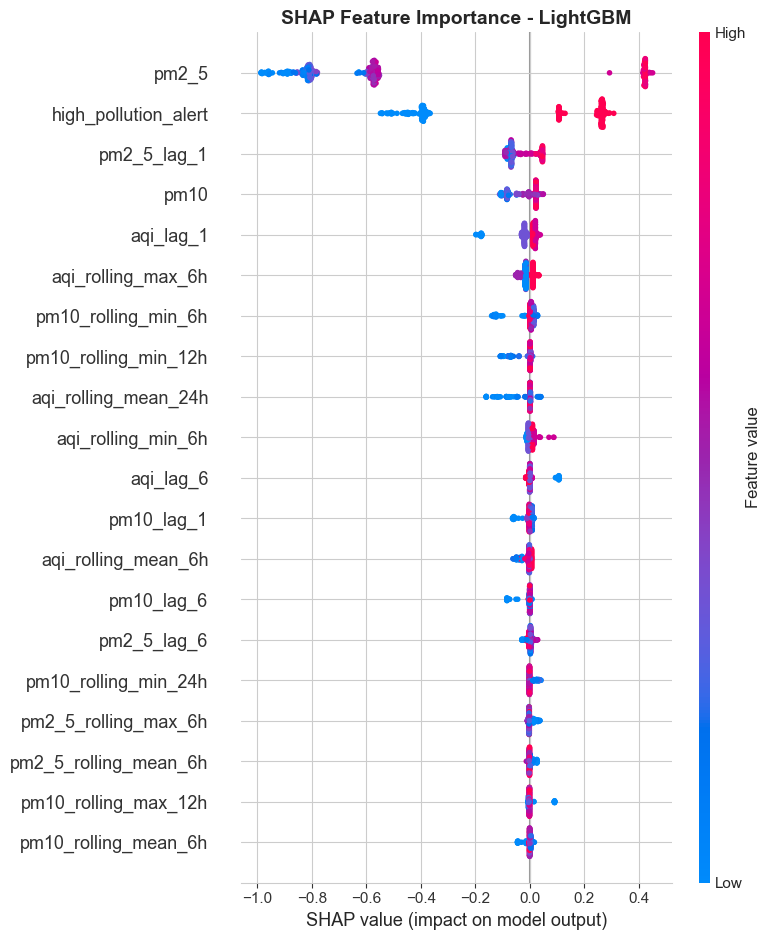

✅ SHAP summary plot generated!


In [19]:
# Summary plot - Feature importance
shap.summary_plot(shap_values, X_test_sample, feature_names=top_features, show=False)
plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ SHAP summary plot generated!")

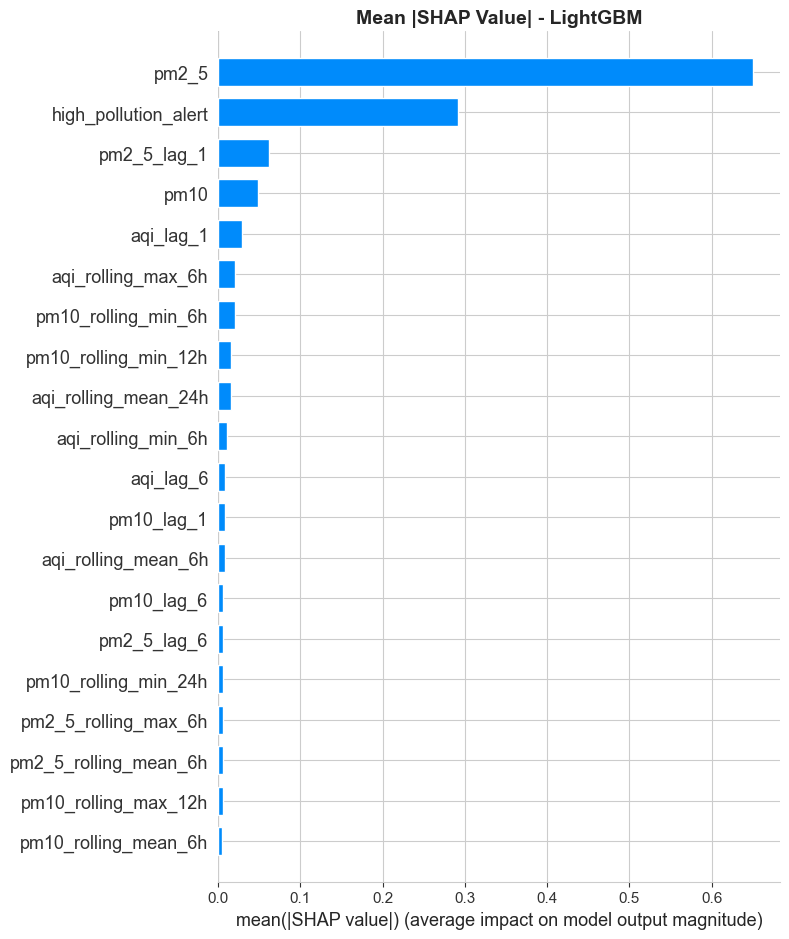

✅ SHAP bar plot generated!


In [20]:
# Bar plot - Mean absolute SHAP values
shap.summary_plot(shap_values, X_test_sample, feature_names=top_features, plot_type="bar", show=False)
plt.title(f'Mean |SHAP Value| - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ SHAP bar plot generated!")

## 8. Save Best Model Locally

In [21]:
# Create models directory if it doesn't exist
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

# Save best model
model_filename = f"{best_model_name.lower()}_aqi_v1.pkl"
model_path = models_dir / model_filename
joblib.dump(best_model, model_path)

# Save scaler
scaler_path = models_dir / "scaler.pkl"
joblib.dump(scaler, scaler_path)

# Save feature names
feature_names_path = models_dir / "feature_names.pkl"
joblib.dump(top_features, feature_names_path)

# Save metadata
metadata = {
    'model_name': best_model_name,
    'model_filename': model_filename,
    'trained_at': datetime.now(timezone.utc).isoformat(),
    'features': top_features,
    'n_features': len(top_features),
    'performance': results[best_model_name]['test'],
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_path = models_dir / "model_metadata.pkl"
joblib.dump(metadata, metadata_path)

print(f"✅ Best model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"✅ Feature names saved to: {feature_names_path}")
print(f"✅ Metadata saved to: {metadata_path}")

✅ Best model saved to: d:\Internships and Jobs Data\10 Pearls Shine Internship\Project\AQI Predictor\models\lightgbm_aqi_v1.pkl
✅ Scaler saved to: d:\Internships and Jobs Data\10 Pearls Shine Internship\Project\AQI Predictor\models\scaler.pkl
✅ Feature names saved to: d:\Internships and Jobs Data\10 Pearls Shine Internship\Project\AQI Predictor\models\feature_names.pkl
✅ Metadata saved to: d:\Internships and Jobs Data\10 Pearls Shine Internship\Project\AQI Predictor\models\model_metadata.pkl


## 9. Save Best Model to MongoDB Registry

In [22]:
print("📤 Saving model to MongoDB model_registry...")

# Serialize model to binary
model_binary = pickle.dumps(best_model)
scaler_binary = pickle.dumps(scaler)

# Prepare registry document
registry_doc = {
    'model_name': best_model_name,
    'version': 'v1',
    'model_binary': model_binary,
    'scaler_binary': scaler_binary,
    'feature_names': top_features,
    'n_features': len(top_features),
    'performance': {
        'test_rmse': float(results[best_model_name]['test']['RMSE']),
        'test_mae': float(results[best_model_name]['test']['MAE']),
        'test_r2': float(results[best_model_name]['test']['R²'])
    },
    'training_info': {
        'trained_at': datetime.now(timezone.utc),
        'training_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'aqi_range': {'min': float(y.min()), 'max': float(y.max())}
    },
    'is_active': True  # Mark as active model for predictions
}

# Save to MongoDB
collection = db_handler.db['model_registry']

# Deactivate all previous models
collection.update_many({}, {'$set': {'is_active': False}})

# Insert new model
result = collection.insert_one(registry_doc)

print(f"✅ Model saved to MongoDB model_registry!")
print(f"   Model ID: {result.inserted_id}")
print(f"   Model: {best_model_name} v1")
print(f"   Performance: RMSE={results[best_model_name]['test']['RMSE']:.4f}, R²={results[best_model_name]['test']['R²']:.4f}")

📤 Saving model to MongoDB model_registry...
✅ Model saved to MongoDB model_registry!
   Model ID: 6985041fb61434a0221a6c45
   Model: LightGBM v1
   Performance: RMSE=0.1923, R²=0.9516


## 10. Summary & Next Steps

In [23]:
print("\n" + "="*80)
print("🎉 MODEL TRAINING COMPLETE!")
print("="*80)
print(f"\n✅ Best Model: {best_model_name}")
print(f"✅ Test RMSE: {results[best_model_name]['test']['RMSE']:.4f}")
print(f"✅ Test MAE: {results[best_model_name]['test']['MAE']:.4f}")
print(f"✅ Test R²: {results[best_model_name]['test']['R²']:.4f}")
print(f"\n📁 Model saved locally: {model_path}")
print(f"📁 MongoDB Registry: ✅ Saved")
print(f"\n🔍 SHAP Analysis: ✅ Completed")
print(f"📊 Top 5 Features:")
for i in range(min(5, len(top_features))):
    print(f"   {i+1}. {top_features[i]}")

print("\n" + "="*80)
print("📋 NEXT STEPS:")
print("="*80)
print("1. ✅ Model trained and saved")
print("2. 📌 Create prediction pipeline for next 3 days")
print("3. 📌 Create AQI alert system")
print("4. 📌 Set up automated daily retraining (GitHub Actions)")
print("="*80)


🎉 MODEL TRAINING COMPLETE!

✅ Best Model: LightGBM
✅ Test RMSE: 0.1923
✅ Test MAE: 0.0796
✅ Test R²: 0.9516

📁 Model saved locally: d:\Internships and Jobs Data\10 Pearls Shine Internship\Project\AQI Predictor\models\lightgbm_aqi_v1.pkl
📁 MongoDB Registry: ✅ Saved

🔍 SHAP Analysis: ✅ Completed
📊 Top 5 Features:
   1. aqi_lag_1
   2. aqi_rolling_mean_6h
   3. aqi_rolling_min_6h
   4. aqi_rolling_max_6h
   5. high_pollution_alert

📋 NEXT STEPS:
1. ✅ Model trained and saved
2. 📌 Create prediction pipeline for next 3 days
3. 📌 Create AQI alert system
4. 📌 Set up automated daily retraining (GitHub Actions)
